In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from tensorflow.keras import optimizers
from glob import glob
import seaborn as sns
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### **In this part, the binary classification of psoriasis and similar conditions is performed.**

In [3]:
train_path = '/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Dataset/Binary Dataset/train'
test_path = '/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Dataset/Binary Dataset/test'

In [4]:
folders = glob('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Dataset/Binary Dataset/train/*')
print(len(folders))

2


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [7]:
test_datagen = ImageDataGenerator(
    rescale=1./255)

In [ ]:
train_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size=32,
                                
                                                 class_mode = 'categorical')

Found 1680 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            batch_size=32,
                                            class_mode = 'categorical')

Found 420 images belonging to 2 classes.


In [ ]:
input_tensor=Input(shape=(224,224,3))

In [ ]:
model1 = ResNet50V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model1.layers:
  layer.tranable=True

In [ ]:
x = GlobalAveragePooling2D(name='Pooling')(model1.output)
x = Flatten(name='flatten')(x)
x=Dropout(0.5)(x)
x = Dense(2,activation='softmax', name='fc2')(x)
model1 = Model(inputs=input_tensor, outputs=x)

In [ ]:
model1.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
sgd = optimizers.SGD()
model1.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_Binary.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model1_history=model1.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.7054
Epoch 1: val_accuracy improved from -inf to 0.76190, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_Binary.hdf5
53/53 [==============================] - 47s 779ms/step - loss: 0.5956 - accuracy: 0.7054 - val_loss: 0.5429 - val_accuracy: 0.7619
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8256
Epoch 2: val_accuracy improved from 0.76190 to 0.80952, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_Binary.hdf5
53/53 [==============================] - 40s 741ms/step - loss: 0.4070 - accuracy: 0.8256 - val_loss: 0.4528 - val_accuracy: 0.8095
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.8804
Epoch 3: val_accuracy improved from 0.80952 to 0.81667, saving model to /content/drive/MyDrive/Research Gro

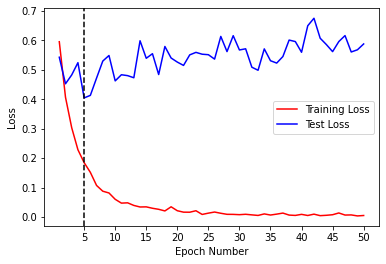

In [ ]:
test_loss=model1_history.history['val_loss']
training_loss=model1_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

In [25]:
network1 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_Binary.hdf5')

In [26]:
test_set_evaluation = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode = 'categorical')

Found 420 images belonging to 2 classes.


In [9]:
network1.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

420/420 [==============================] - 180s 403ms/step - loss: 0.4987 - accuracy: 0.9095


[0.49872270226478577, 0.9095237851142883]

420/420 [==============================] - 6s 13ms/step


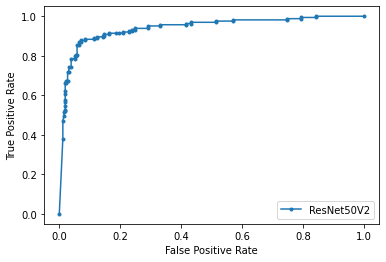

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
probs=network1.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(test_set_evaluation.classes, probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ResNet50V2')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [28]:
# AUC Score
from sklearn.metrics import roc_auc_score
roc_auc_score(test_set_evaluation.classes, probs)

0.9413119763194958

In [ ]:
# Making Predictions
predictions1=network1.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds1=np.argmax(predictions1, axis=1)

420/420 [==============================] - 9s 19ms/step


0.9095238095238095

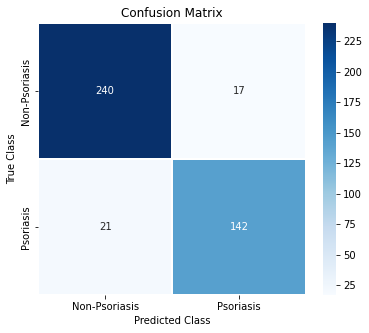

In [ ]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds1)
ax=plt.figure(figsize=(6,5))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis']); ax.yaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds1)

In [ ]:
model2 = ResNet101V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model2.layers:
  layer.tranable=True

171327488/171317808 [==============================] - 5s 0us/step


In [ ]:
x = GlobalAveragePooling2D(name='Pooling')(model2.output)
x = Flatten(name='flatten')(x)
x=Dropout(0.5)(x)
x = Dense(2,activation='softmax', name='fc2')(x)
model2 = Model(inputs=input_tensor, outputs=x)

In [ ]:
model2.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_Binary.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model2_history=model2.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.7167
Epoch 1: val_accuracy improved from -inf to 0.74762, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_Binary.hdf5
53/53 [==============================] - 80s 1s/step - loss: 0.5751 - accuracy: 0.7167 - val_loss: 0.5467 - val_accuracy: 0.7476
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8268
Epoch 2: val_accuracy improved from 0.74762 to 0.78571, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_Binary.hdf5
53/53 [==============================] - 65s 1s/step - loss: 0.3950 - accuracy: 0.8268 - val_loss: 0.4744 - val_accuracy: 0.7857
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.8792
Epoch 3: val_accuracy did not improve from 0.78571
53/53 [==============================] - 62s 1s/step - loss:

In [29]:
network2 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_Binary.hdf5')

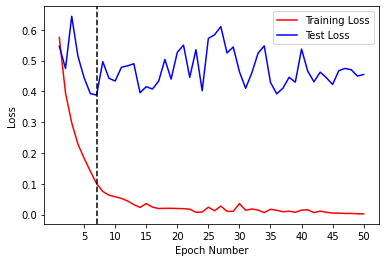

In [ ]:
test_loss=model2_history.history['val_loss']
training_loss=model2_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

In [ ]:
network2.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

420/420 [==============================] - 20s 43ms/step - loss: 0.3921 - accuracy: 0.9095


[0.3921211361885071, 0.9095237851142883]

In [ ]:
# Making Predictions
predictions2=network2.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds2=np.argmax(predictions2, axis=1)

420/420 [==============================] - 17s 37ms/step


420/420 [==============================] - 9s 18ms/step


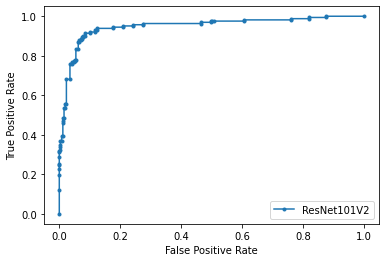

In [30]:
probs=network2.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(test_set_evaluation.classes, probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ResNet101V2')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [31]:
# AUC Score
roc_auc_score(test_set_evaluation.classes, probs)

0.9491418204387577

0.9095238095238095

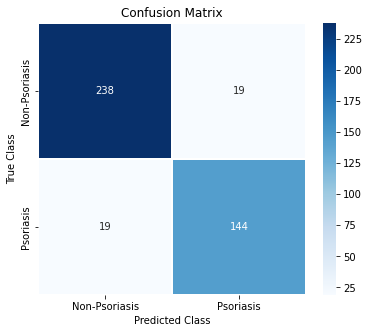

In [ ]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds2)
ax=plt.figure(figsize=(6,5))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis']); ax.yaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds2)

In [ ]:
model3 = ResNet152V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model3.layers:
  layer.tranable=True

234561536/234545216 [==============================] - 8s 0us/step


In [ ]:
x = GlobalAveragePooling2D(name='Pooling')(model3.output)
x = Flatten(name='flatten')(x)
x=Dropout(0.5)(x)
x = Dense(2,activation='softmax', name='fc2')(x)
model3 = Model(inputs=input_tensor, outputs=x)

In [ ]:
model3.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model3.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_Binary.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model3_history=model3.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 0.5738 - accuracy: 0.7173
Epoch 1: val_accuracy improved from -inf to 0.74286, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_Binary.hdf5
53/53 [==============================] - 118s 2s/step - loss: 0.5738 - accuracy: 0.7173 - val_loss: 0.5244 - val_accuracy: 0.7429
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 0.3876 - accuracy: 0.8357
Epoch 2: val_accuracy did not improve from 0.74286
53/53 [==============================] - 91s 2s/step - loss: 0.3876 - accuracy: 0.8357 - val_loss: 0.5617 - val_accuracy: 0.7405
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.8875
Epoch 3: val_accuracy improved from 0.74286 to 0.83571, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_Binary.hdf5
53/53 [==============================] - 95s 2s/step - loss

In [32]:
network3 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_Binary.hdf5')

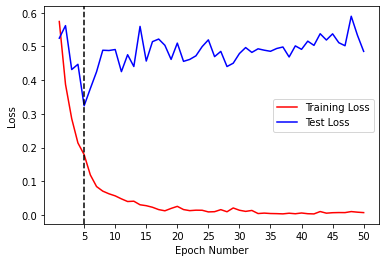

In [ ]:
test_loss=model3_history.history['val_loss']
training_loss=model3_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

420/420 [==============================] - 16s 31ms/step


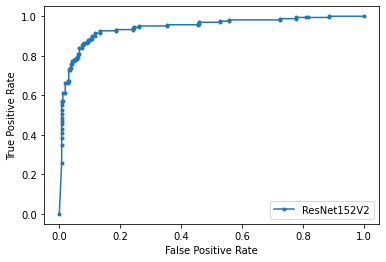

In [33]:
probs=network3.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(test_set_evaluation.classes, probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ResNet152V2')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [34]:
# AUC Score
roc_auc_score(test_set_evaluation.classes, probs)

0.9437110596548184

In [ ]:
network3.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

420/420 [==============================] - 28s 61ms/step - loss: 0.4404 - accuracy: 0.8952


[0.44039666652679443, 0.8952381014823914]

In [ ]:
# Making Predictions
predictions3=network3.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds3=np.argmax(predictions3, axis=1)

420/420 [==============================] - 25s 53ms/step


0.8952380952380953

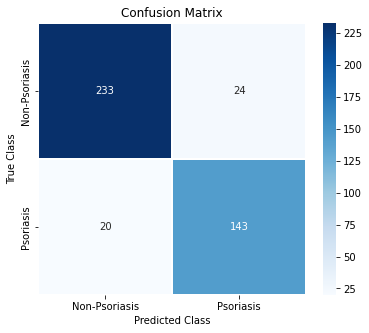

In [ ]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds3)
ax=plt.figure(figsize=(6,5))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis']); ax.yaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds3)

In [ ]:
networks = [network1, network2, network3]
preds_1 = [network.predict(test_set_evaluation) for network in networks]
preds_1=np.array(preds_1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds_1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(test_set.classes, wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                          'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])    

Max accuracy of  91.9047619047619  obained with w1= 0.1  w2= 0.4  and w3= 0.4


In [ ]:
networks = [network1, network2, network3]
preds = [network.predict(test_set_evaluation) for network in networks]
preds=np.array(preds)
ideal_weights = [max_acc_row[0], max_acc_row[1], max_acc_row[2]] 
np.save('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/weights_binary.npy', ideal_weights)
#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(test_set.classes, ideal_weighted_ensemble_prediction)

[Text(0, 0.5, 'Non-Psoriasis'), Text(0, 1.5, 'Psoriasis')]

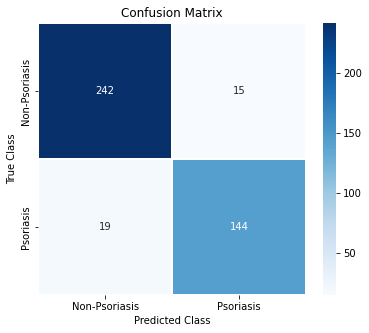

In [ ]:
cf_matrix=confusion_matrix(test_set_evaluation.classes, ideal_weighted_ensemble_prediction)
ax=plt.figure(figsize=(6,5))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis']); ax.yaxis.set_ticklabels(['Non-Psoriasis', 'Psoriasis'])

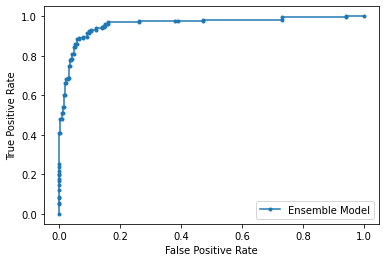

In [22]:
networks = [network1, network2, network3]
preds = [network.predict(test_set_evaluation) for network in networks]
preds=np.array(preds)
ideal_weights=np.load('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/weights_binary.npy')
#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))

# keep probabilities for the positive outcome only
probs = ideal_weighted_preds[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(test_set_evaluation.classes, probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Ensemble Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [24]:
roc_auc_score(test_set_evaluation.classes, probs)

0.9593946193693156

### **In this part, the multi-class classification of variants of psoriasis is performed.**

In [ ]:
train_path = '/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Multi Class Dataset/train'
test_path = '/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Multi Class Dataset/test'

In [ ]:
folders = glob('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Multi Class Dataset/train/*')
print(len(folders))

7


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255)

In [ ]:
train_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size=32,
                                
                                                 class_mode = 'categorical')

Found 649 images belonging to 7 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            batch_size=32,
                                            class_mode = 'categorical')

Found 164 images belonging to 7 classes.


In [ ]:
input_tensor=Input(shape=(224,224,3))

In [ ]:
model1 = ResNet50V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model1.layers:
  layer.tranable=True

In [ ]:
x = GlobalAveragePooling2D(name='Pooling')(model1.output)
x = Flatten(name='flatten')(x)
x=Dropout(0.5)(x)
x = Dense(7,activation='softmax', name='fc2')(x)
model1 = Model(inputs=input_tensor, outputs=x)

In [ ]:
model1.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model1.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_MultiClass.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model1_history=model1.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.4757 - accuracy: 0.4854
Epoch 1: val_accuracy improved from -inf to 0.59146, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_MultiClass.hdf5
21/21 [==============================] - 267s 13s/step - loss: 1.4757 - accuracy: 0.4854 - val_loss: 1.2590 - val_accuracy: 0.5915
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.8988 - accuracy: 0.6980
Epoch 2: val_accuracy improved from 0.59146 to 0.70732, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_MultiClass.hdf5
21/21 [==============================] - 16s 758ms/step - loss: 0.8988 - accuracy: 0.6980 - val_loss: 0.8978 - val_accuracy: 0.7073
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.7982
Epoch 3: val_accuracy did not improve from 0.70732
21/21 [==============================] - 16s 727m

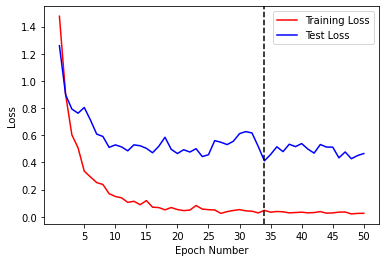

In [ ]:
test_loss=model1_history.history['val_loss']
training_loss=model1_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

In [ ]:
network1 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet50V2_MultiClass.hdf5')

In [ ]:
test_set_evaluation = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode = 'categorical')

Found 164 images belonging to 7 classes.


In [ ]:
test_set_evaluation = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode = 'categorical')
network1.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

Found 164 images belonging to 7 classes.
164/164 [==============================] - 6s 25ms/step - loss: 0.4565 - accuracy: 0.9085


[0.45647457242012024, 0.9085366129875183]

In [ ]:
# Making Predictions
predictions1=network1.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds1=np.argmax(predictions1, axis=1)

164/164 [==============================] - 4s 19ms/step


0.9085365853658537

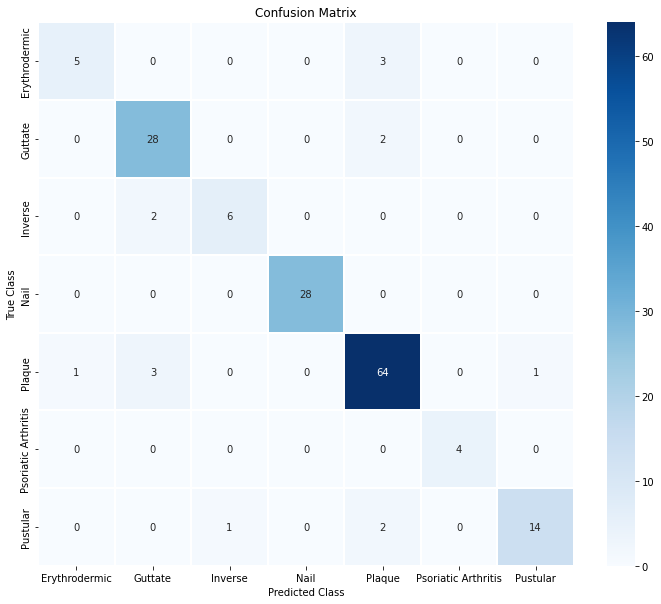

In [ ]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds1)
ax=plt.figure(figsize=(12,10))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular']); ax.yaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds1)

In [ ]:
model2 = ResNet101V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model2.layers:
  layer.tranable=True

In [ ]:
x = GlobalAveragePooling2D(name='Pooling')(model2.output)
x = Flatten(name='flatten')(x)
x=Dropout(0.5)(x)
x = Dense(7,activation='softmax', name='fc2')(x)
model2 = Model(inputs=input_tensor, outputs=x)

In [ ]:
model2.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_MultiClass.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model2_history=model2.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.5886 - accuracy: 0.4561
Epoch 1: val_accuracy improved from -inf to 0.56098, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_MultiClass.hdf5
21/21 [==============================] - 44s 2s/step - loss: 1.5886 - accuracy: 0.4561 - val_loss: 1.2959 - val_accuracy: 0.5610
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.8740 - accuracy: 0.6934
Epoch 2: val_accuracy improved from 0.56098 to 0.60976, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_MultiClass.hdf5
21/21 [==============================] - 27s 1s/step - loss: 0.8740 - accuracy: 0.6934 - val_loss: 1.2590 - val_accuracy: 0.6098
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.6058 - accuracy: 0.7997
Epoch 3: val_accuracy improved from 0.60976 to 0.71341, saving model to /content/drive/MyDrive/Research

In [ ]:
network2 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet101V2_MultiClass.hdf5')

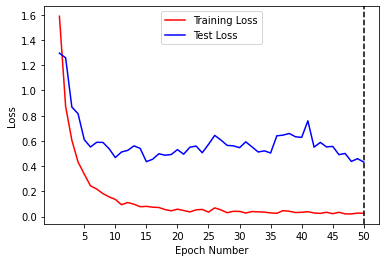

In [ ]:
test_loss=model2_history.history['val_loss']
training_loss=model2_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

In [ ]:
network2.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

164/164 [==============================] - 9s 44ms/step - loss: 0.5216 - accuracy: 0.8963


[0.5215834975242615, 0.8963414430618286]

In [ ]:
# Making Predictions
predictions2=network2.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds2=np.argmax(predictions2, axis=1)

164/164 [==============================] - 8s 37ms/step


0.8963414634146342

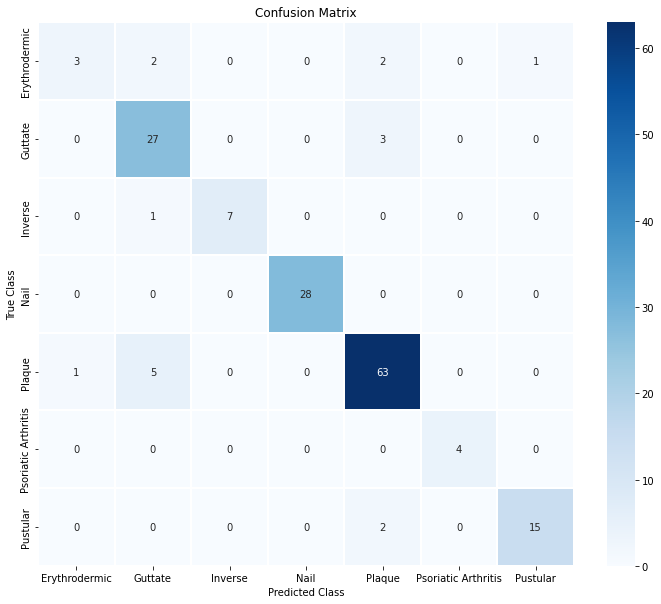

In [ ]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds2)
ax=plt.figure(figsize=(12,10))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular']); ax.yaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds2)

In [ ]:
model3 = ResNet152V2(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in model3.layers:
  layer.tranable=True

In [ ]:
x = GlobalAveragePooling2D(name='Pooling')(model3.output)
x = Flatten(name='flatten')(x)
x=Dropout(0.5)(x)
x = Dense(7,activation='softmax', name='fc2')(x)
model3 = Model(inputs=input_tensor, outputs=x)

In [ ]:
model3.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model3.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_MultiClass.hdf5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model3_history=model3.fit(
    train_set,
  validation_data=test_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.4744 - accuracy: 0.4838
Epoch 1: val_accuracy improved from -inf to 0.49390, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_MultiClass.hdf5
21/21 [==============================] - 64s 2s/step - loss: 1.4744 - accuracy: 0.4838 - val_loss: 1.2471 - val_accuracy: 0.4939
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.7756 - accuracy: 0.7350
Epoch 2: val_accuracy improved from 0.49390 to 0.56098, saving model to /content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_MultiClass.hdf5
21/21 [==============================] - 39s 2s/step - loss: 0.7756 - accuracy: 0.7350 - val_loss: 1.2294 - val_accuracy: 0.5610
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.8043
Epoch 3: val_accuracy improved from 0.56098 to 0.68293, saving model to /content/drive/MyDrive/Research

In [ ]:
network3 = load_model('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/ResNet152V2_MultiClass.hdf5')

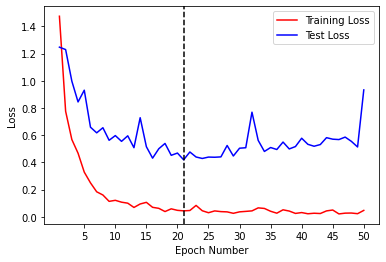

In [ ]:
test_loss=model3_history.history['val_loss']
training_loss=model3_history.history['loss']
epoch_count=range(1, len(test_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, test_loss, 'b-')
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='k',label='Minimum Test Loss')
plt.xticks(np.arange(5, 51, 5))
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

In [ ]:
network3.evaluate(test_set_evaluation, steps=len(test_set_evaluation))

164/164 [==============================] - 13s 63ms/step - loss: 0.5134 - accuracy: 0.9024


[0.5134321451187134, 0.9024389982223511]

In [ ]:
# Making Predictions
predictions3=network3.predict(test_set_evaluation, steps=len(test_set_evaluation), verbose=1)
preds3=np.argmax(predictions3, axis=1)

164/164 [==============================] - 12s 54ms/step


0.9024390243902439

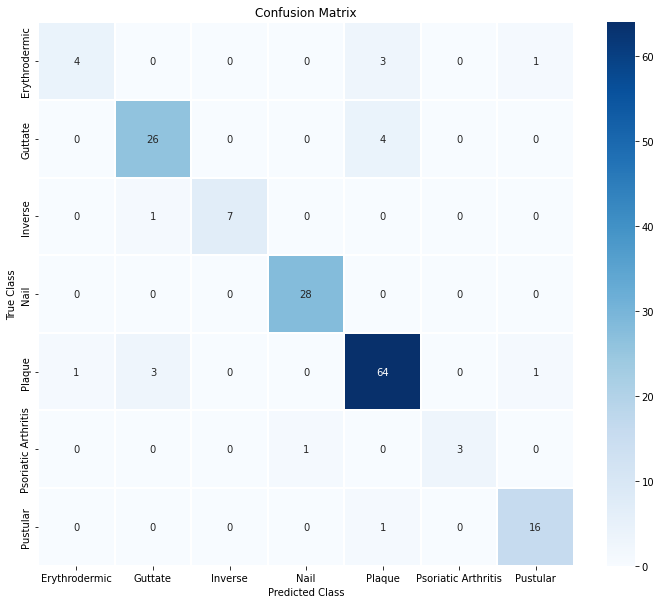

In [ ]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds3)
ax=plt.figure(figsize=(12,10))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular']); ax.yaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular'])
from sklearn.metrics import accuracy_score
accuracy_score(test_set_evaluation.classes, preds3)

In [ ]:
networks = [network1, network2, network3]
preds_1 = [network.predict(test_set_evaluation) for network in networks]
preds_1=np.array(preds_1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds_1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(test_set.classes, wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                          'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])    

Max accuracy of  93.29268292682927  obained with w1= 0.4  w2= 0.0  and w3= 0.3


In [ ]:
networks = [network1, network2, network3]
preds = [network.predict(test_set_evaluation) for network in networks]
preds=np.array(preds)
ideal_weights = [max_acc_row[0], max_acc_row[1], max_acc_row[2]] 
np.save('/content/drive/MyDrive/Research Group UT SUT UoA/Technical Calculations/Results/weights_MultiClass.npy', ideal_weights)
#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(test_set.classes, ideal_weighted_ensemble_prediction)

[Text(0, 0.5, 'Erythrodermic'),
 Text(0, 1.5, 'Guttate'),
 Text(0, 2.5, 'Inverse'),
 Text(0, 3.5, 'Nail'),
 Text(0, 4.5, 'Plaque'),
 Text(0, 5.5, 'Psoriatic Arthritis'),
 Text(0, 6.5, 'Pustular')]

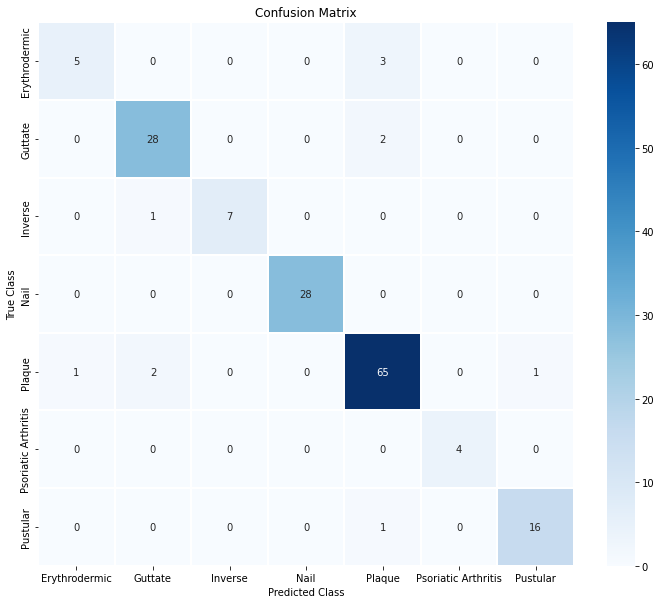

In [ ]:
cf_matrix=confusion_matrix(test_set_evaluation.classes, ideal_weighted_ensemble_prediction)
ax=plt.figure(figsize=(12,10))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular']); ax.yaxis.set_ticklabels(['Erythrodermic', 'Guttate', 'Inverse', 'Nail', 'Plaque', 'Psoriatic Arthritis', 'Pustular'])